# Initialization

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_94/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
!pip install boto3 astropy sfdmap progressbar2 GPUtil parse

  Using cached boto3-1.26.114-py3-none-any.whl (135 kB)
  Using cached sfdmap-0.1.1-py3-none-any.whl
  Using cached progressbar2-4.2.0-py2.py3-none-any.whl (27 kB)
  Using cached GPUtil-1.4.0-py3-none-any.whl
  Using cached parse-1.19.0-py3-none-any.whl
  Using cached s3transfer-0.6.0-py3-none-any.whl (79 kB)
  Using cached jmespath-1.0.1-py3-none-any.whl (20 kB)
  Using cached botocore-1.29.114-py3-none-any.whl (10.6 MB)
  Using cached python_utils-3.5.2-py2.py3-none-any.whl (24 kB)


In [3]:
# imports
import pandas as pd
import numpy as np
import os
import sys
import pickle
import boto3
from matplotlib import pyplot as plt
import time

# random seed
seed = 42
np.random.seed(seed)

# local files paths
local_home_dir_path = os.path.expanduser("~")
local_work_dir_path = os.path.join(local_home_dir_path, 'thesis2')
local_code_dir_path = os.path.join(local_work_dir_path , 'code')

# S3 file paths
endpoint_url = 'https://s3-west.nrp-nautilus.io'
bucket_name = 'tau-astro'
prefix = 'almogh'
s3_work_dir_path = os.path.join(prefix, 'thesis2')
s3_data_dir_path = os.path.join(s3_work_dir_path , 'data')
s3_models_dir_path = os.path.join(s3_work_dir_path , 'models')
s3_final_table_csv_path = os.path.join(s3_data_dir_path, 'SDSS_DR16_all.csv')

s3_client = boto3.client("s3", endpoint_url=endpoint_url)

# adding code folder to path
sys.path.insert(1, local_code_dir_path)
from s3 import to_s3_npy, to_s3_pkl, from_s3_npy, from_s3_pkl, to_s3_fig, from_s3_parquet, from_s3_csv, from_s3_pickle

2023-04-15 09:38:10.302807: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-15 09:38:10.343020: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-15 09:38:11.014705: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Load Data

## Load the dataset

In [4]:
s3_data_dir_path_in_bucket = 'almogh/thesis2/data/BigRF/train/'
X = from_s3_npy(s3_client = s3_client, bucket_name = bucket_name,
    path_in_bucket = os.path.join(s3_data_dir_path_in_bucket,'spec.npy'))
wl_grid = from_s3_npy(s3_client = s3_client, bucket_name = bucket_name,
    path_in_bucket = os.path.join(s3_data_dir_path_in_bucket,'wl_grid.npy'))
ivar = from_s3_npy(s3_client = s3_client, bucket_name = bucket_name,
    path_in_bucket = os.path.join(s3_data_dir_path_in_bucket,'ivar.npy'))

loading from uri: s3://tau-astro/almogh/thesis2/data/BigRF/train/spec.npy
loading from uri: s3://tau-astro/almogh/thesis2/data/BigRF/train/wl_grid.npy
loading from uri: s3://tau-astro/almogh/thesis2/data/BigRF/train/ivar.npy


In [5]:
gs = from_s3_pickle(s3_client = s3_client, bucket_name = bucket_name,
    path_in_bucket = os.path.join(s3_data_dir_path_in_bucket,'gs.pkl'))

loading from uri: s3://tau-astro/almogh/thesis2/data/BigRF/train/gs.pkl


## Load the Distance Matrices

In [6]:
s3_inference_dir_path_in_bucket = 'almogh/thesis2/eval/inference'
D_NN = from_s3_npy(s3_client = s3_client, bucket_name = bucket_name,
    path_in_bucket = os.path.join(s3_inference_dir_path_in_bucket,'D_NN2.npy'))
D_BigRF = from_s3_npy(s3_client = s3_client, bucket_name = bucket_name,
    path_in_bucket = os.path.join(s3_inference_dir_path_in_bucket,'D_BigRF.npy'))
D_SmallRF = from_s3_npy(s3_client = s3_client, bucket_name = bucket_name,
    path_in_bucket = os.path.join(s3_inference_dir_path_in_bucket,'D_SmallRF.npy'))

loading from uri: s3://tau-astro/almogh/thesis2/eval/inference/D_NN2.npy
loading from uri: s3://tau-astro/almogh/thesis2/eval/inference/D_BigRF.npy
loading from uri: s3://tau-astro/almogh/thesis2/eval/inference/D_SmallRF.npy


## Calculate weirdness scores

In [9]:
NN_scores = np.mean(D_NN, axis=1)
SmallRF_scores = np.mean(D_SmallRF, axis=1)
BigRF_scores = np.mean(D_BigRF, axis=1)

In [10]:
gs['NN score'] = NN_scores
gs['SmallRF score'] = SmallRF_scores
gs['BigRF score'] = BigRF_scores

In [11]:
from joblib import Parallel, delayed

def mean_distance_to_KNN_i(i, d, K):
    return i,np.mean(np.sort(d)[:K])
    
def mean_distance_to_KNN(D, K):
    res = Parallel(n_jobs=-1, verbose=5)(delayed(mean_distance_to_KNN_i)(i, D[i], K) for i in range(len(D)))
    res = np.array(sorted(res, key=lambda x: x[0]))
    return np.array([x[1] for x in res])

In [12]:
K = 100
NN_scores_knn = mean_distance_to_KNN(D_NN, K)
SmallRF_scores_knn = mean_distance_to_KNN(D_SmallRF, K)
BigRF_scores_knn = mean_distance_to_KNN(D_BigRF, K)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 4880 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 8048 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 11792 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 16112 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 21008 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 26480 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 32528 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 39152 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 46352 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 54128 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 62480 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 71408 

In [13]:
gs['NN score knn'] = NN_scores_knn
gs['SmallRF score knn'] = SmallRF_scores_knn
gs['BigRF score knn'] = BigRF_scores_knn

## pearson correlation coefficient

In [14]:
from scipy import stats

In [15]:
stats.pearsonr(gs['snMedian'],gs['weirdness'])

PearsonRResult(statistic=0.19803002864222763, pvalue=0.0)

In [16]:
stats.pearsonr(gs['snMedian'],gs['BigRF score'])

PearsonRResult(statistic=-0.34904273036290856, pvalue=0.0)

In [17]:
stats.pearsonr(gs['snMedian'],gs['SmallRF score'])

PearsonRResult(statistic=-0.14945449036424593, pvalue=0.0)

In [18]:
stats.pearsonr(gs['snMedian'],gs['NN score'])

PearsonRResult(statistic=-0.09499440041077321, pvalue=3.8542338780205277e-199)

In [19]:
stats.pearsonr(gs['snMedian'],gs['BigRF score knn'])

PearsonRResult(statistic=-0.5686678883111068, pvalue=0.0)

In [20]:
stats.pearsonr(gs['snMedian'],gs['SmallRF score knn'])

PearsonRResult(statistic=-0.11267954618019943, pvalue=7.676771149119366e-280)

In [21]:
stats.pearsonr(gs['snMedian'],gs['NN score knn'])

PearsonRResult(statistic=0.093363938438752, pvalue=2.0980847588309888e-192)

## mean score vs SNR

In [22]:
N_bins = 20

In [23]:
I_bins = np.linspace(0,len(gs),N_bins).astype(int)
gs_snr_sorted = gs.sort_values(by='snMedian')
gs_snr_sorted.index = np.arange(len(gs_snr_sorted))

In [24]:
def calc_bins_mean_over_col(df_sorted, col_name, I_bins):
    return np.array([np.mean(df_sorted[I_bins[i]:I_bins[i+1]][col_name]) for i in range(len(I_bins)-1)])
    
def calc_bins_std_over_col(df_sorted, col_name, I_bins):
    return np.array([np.std(df_sorted[I_bins[i]:I_bins[i+1]][col_name]) for i in range(len(I_bins)-1)])

In [25]:
snr_mean =  calc_bins_mean_over_col(gs_snr_sorted, 'snMedian', I_bins)
snr_std =  calc_bins_std_over_col(gs_snr_sorted, 'snMedian', I_bins)

In [26]:
weirdness_mean =  calc_bins_mean_over_col(gs_snr_sorted, 'weirdness', I_bins)
weirdness_std =  calc_bins_std_over_col(gs_snr_sorted, 'weirdness', I_bins)

In [27]:
BigRF_score_mean =  calc_bins_mean_over_col(gs_snr_sorted, 'BigRF score', I_bins)
BigRF_score_std =  calc_bins_std_over_col(gs_snr_sorted, 'BigRF score', I_bins)

In [28]:
SmallRF_score_mean =  calc_bins_mean_over_col(gs_snr_sorted, 'SmallRF score', I_bins)
SmallRF_score_std =  calc_bins_std_over_col(gs_snr_sorted, 'SmallRF score', I_bins)

In [29]:
NN_score_mean =  calc_bins_mean_over_col(gs_snr_sorted, 'NN score', I_bins)
NN_score_std =  calc_bins_std_over_col(gs_snr_sorted, 'NN score', I_bins)

In [30]:
BigRF_score_knn_mean =  calc_bins_mean_over_col(gs_snr_sorted, 'BigRF score knn', I_bins)
BigRF_score_knn_std =  calc_bins_std_over_col(gs_snr_sorted, 'BigRF score knn', I_bins)

In [31]:
SmallRF_score_knn_mean =  calc_bins_mean_over_col(gs_snr_sorted, 'SmallRF score knn', I_bins)
SmallRF_score_knn_std =  calc_bins_std_over_col(gs_snr_sorted, 'SmallRF score knn', I_bins)

In [32]:
NN_score_knn_mean =  calc_bins_mean_over_col(gs_snr_sorted, 'NN score knn', I_bins)
NN_score_knn_std =  calc_bins_std_over_col(gs_snr_sorted, 'NN score knn', I_bins)

Text(0, 0.5, 'Mean Score')

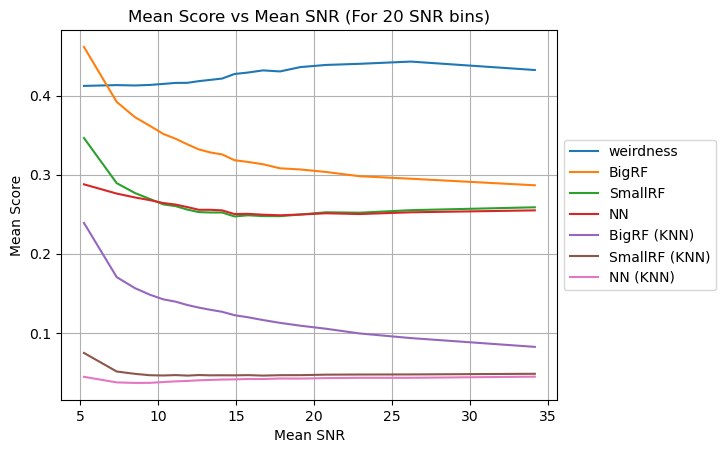

In [33]:
plt.plot(snr_mean,weirdness_mean,label='weirdness')
plt.plot(snr_mean,BigRF_score_mean,label='BigRF')
plt.plot(snr_mean,SmallRF_score_mean,label='SmallRF')
plt.plot(snr_mean,NN_score_mean,label='NN')
plt.plot(snr_mean,BigRF_score_knn_mean,label='BigRF (KNN)')
plt.plot(snr_mean,SmallRF_score_knn_mean,label='SmallRF (KNN)')
plt.plot(snr_mean,NN_score_knn_mean,label='NN (KNN)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.title('Mean Score vs Mean SNR (For 20 SNR bins)')
plt.xlabel('Mean SNR')
plt.ylabel('Mean Score')

plt.errorbar(snr_mean,weirdness_mean,xerr=None,yerr=weirdness_std,label='weirdness')
plt.errorbar(snr_mean,BigRF_score_mean,xerr=None,yerr=BigRF_score_std,label='BigRF')
plt.errorbar(snr_mean,SmallRF_score_mean,xerr=None,yerr=SmallRF_score_std,label='SmallRF')
plt.errorbar(snr_mean,NN_score_mean,xerr=None,yerr=NN_score_std,label='NN')
plt.errorbar(snr_mean,BigRF_score_knn_mean,xerr=None,yerr=BigRF_score_knn_std,label='BigRF (KNN)')
plt.errorbar(snr_mean,SmallRF_score_knn_mean,xerr=None,yerr=SmallRF_score_knn_std,label='SmallRF (KNN)')
plt.errorbar(snr_mean,NN_score_knn_mean,xerr=None,yerr=NN_score_knn_std,label='NN (KNN)')
plt.legend()
plt.grid()